In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import hydra
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from torch.quasirandom import SobolEngine
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose


from smallresnet import SmallResNet
from fashionmnist import FashionMNIST
from bayesian_optimizer import BayesianOptimizer
from utils import sobol_lrs

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [8]:
def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



In [9]:
def build_dataloaders(cfg: DictConfig):
    ds = FashionMNIST(batch_size=cfg.batch_size, val_ratio=cfg.val_ratio)

    train_loader = ds.get_train_loader()
    val_loader = ds.get_val_loader()

    return train_loader, val_loader


In [10]:
def accuracy(pred, true):
    class_index_pred = pred.argmax(dim=1)
    correct = (class_index_pred == true).sum().item()
    return correct / true.size(0)

def run_optimizing_function(device, lr, train_loader, val_loader, epochs):
    # initialize model
    model = SmallResNet(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    val_losses = []
    train_losses = []
    avg_train_loss = 0.0
    avg_train_acc = 0.0
    avg_val_loss = 0.0
    avg_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loop = tqdm(train_loader, desc=f"Train (lr={lr:.1e})")
        total_train_loss = 0.0
        total_train_acc = 0.0
        for images, labels in train_loop:
            images = images.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_train_loss += loss.item()
            total_train_acc += accuracy(outputs, labels)
    
            if not np.isfinite(loss.item()):
                print(f"[WARN] Loss is {loss.item()} at lr={lr:.1e}. Returning huge loss.")
                fake_val_loss = 10.0
                return -fake_val_loss, model
                
            loss.backward()
            optimizer.step()
    
            train_acc = accuracy(outputs, labels)
            train_loop.set_postfix({"Loss": loss.item(),
                                    "Accuracy": train_acc})

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
            
        print("Validating")
        model.eval()
        with torch.no_grad():
            # Validation Loss
            total_val_loss = 0.0
            total_val_acc = 0.0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                total_val_loss += criterion(outputs, labels).item()
                total_val_acc += accuracy(outputs, labels)
    
            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_acc = total_val_acc / len(val_loader)
            if not np.isfinite(avg_val_loss):
                print(f"[WARN] avg_val_loss is {avg_val_loss} at lr={lr:.1e}. Forcing to 10.0")
                avg_val_loss = 10.0
            print("--> Validation-Loss :%.4f & Validation-Accuracy: %.4f" % (avg_val_loss, avg_val_acc))

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    plt.figure(figsize=(8, 5))
    
    plt.plot(epochs, train_losses, marker='o', label="Train Loss")

    plt.plot(epochs, val_losses, marker='o', label="Validation Loss")

    print("train_losses: "+str(train_losses))
    print("val losses: "+str(val_losses))

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()

    ### TODO
    plt.savefig(f"results/{lr}_epoch_losses.png", dpi=200)

    return -avg_val_loss, model


In [11]:
def run_single_bo_experiment(cfg: DictConfig, seed: int):
    print(f"\n========== Seed {seed} ==========")
    set_global_seed(seed)

    device = torch.device(cfg.device)

    train_loader, val_loader = build_dataloaders(cfg)

    # --- GP & BO setup ---
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        normalize_y=True,
    )

    bound = [cfg.bound.low, cfg.bound.high]

    bo = BayesianOptimizer(
        f=lambda lr: run_optimizing_function(device, lr, train_loader, val_loader, epochs=cfg.epochs),
        gp=gp,
        mode="log",
        bound=bound,
        path=cfg.result_path,
        size_search_space=250
    )

    n_total = cfg.n_total
    n_sobol = cfg.n_sobol
    n_iter = n_total - n_sobol

    sobol_init_lrs = sobol_lrs(n_sobol, bound, seed=seed)
    print("Sobol-Start-LRs:", sobol_init_lrs)

    x_max = 0

    for lr in sobol_init_lrs:
        x_max, best_return_x, best_return_param = bo.eval(1, lr)
        print(f"{lr} from Sobol: {x_max}")

    x_max, found_lr, best_model = bo.eval(n_iter=n_iter, init_x_max=x_max)
    
    print(f"[Seed {seed}] --> Found learning rate after {n_iter} BO-iterations: {found_lr:.6f}")

    bo.plot_all_in_one(cols=1, folder_path=cfg.result_path, seed=seed)

    best_y = max([pt[1] for pt in bo.dataset])
    return {
        "seed": seed,
        "found_lr": float(found_lr),
        "best_y": float(best_y),
    }

Config:
 epochs: 1
seeds:
- 0
n_total: 10
n_sobol: 3
bound:
  low: 0.0001
  high: 0.2
batch_size: 64
val_ratio: 0.2
result_path: results/
device: mps


========== Seed 0 ==========
Sobol-Start-LRs: [0.0037012  0.0070629  0.18226452]
BO Iteration 1 --> Chosen parameter: 0.0037012046168097756


Train (lr=3.7e-03): 100%|█| 750/750 [00:28<00:00, 26.78it/s, Loss=1.13, Accuracy=0


Validating
--> Validation-Loss :1.0630 & Validation-Accuracy: 0.6626
train_losses: [1.4868347114721934]
val losses: [1.0629688304789522]
0.0037012046168097756 from Sobol: 0.20000000000000004
BO Iteration 2 --> Chosen parameter: 0.007062904024842492


Train (lr=7.1e-03): 100%|█| 750/750 [00:27<00:00, 26.84it/s, Loss=0.852, Accuracy=


Validating
--> Validation-Loss :0.8163 & Validation-Accuracy: 0.6983
train_losses: [1.2412785880565644]
val losses: [0.8162580398803062]
0.007062904024842492 from Sobol: 0.0071779561477931944
BO Iteration 3 --> Chosen parameter: 0.1822645249570934


Train (lr=1.8e-01): 100%|█| 750/750 [00:22<00:00, 34.00it/s, Loss=0.639, Accuracy=


Validating
--> Validation-Loss :0.6107 & Validation-Accuracy: 0.7671
train_losses: [0.8016578258275986]
val losses: [0.6107208552829763]
0.1822645249570934 from Sobol: 0.17701146700110712
BO Iteration 4 --> Chosen parameter: 0.17701146700110712


Train (lr=1.8e-01): 100%|█| 750/750 [00:19<00:00, 37.61it/s, Loss=0.602, Accuracy=


Validating
--> Validation-Loss :0.5963 & Validation-Accuracy: 0.7895
train_losses: [0.7878733749787012]
val losses: [0.5963024303634116]
BO Iteration 5 --> Chosen parameter: 0.13044574444085555


Train (lr=1.3e-01): 100%|█| 750/750 [00:21<00:00, 34.55it/s, Loss=0.655, Accuracy=


Validating
--> Validation-Loss :0.6263 & Validation-Accuracy: 0.7722
train_losses: [0.7823789806365967]
val losses: [0.6263124061391708]
BO Iteration 6 --> Chosen parameter: 0.1566652972494203


Train (lr=1.6e-01): 100%|█| 750/750 [00:21<00:00, 34.46it/s, Loss=0.67, Accuracy=0


Validating
--> Validation-Loss :1.4122 & Validation-Accuracy: 0.5518
train_losses: [0.819532726685206]
val losses: [1.4121695119649806]
BO Iteration 7 --> Chosen parameter: 0.12272007681124596


Train (lr=1.2e-01): 100%|█| 750/750 [00:21<00:00, 34.99it/s, Loss=0.695, Accuracy=


Validating
--> Validation-Loss :0.7223 & Validation-Accuracy: 0.7346
train_losses: [0.7834509405692418]
val losses: [0.722281813780044]
BO Iteration 8 --> Chosen parameter: 0.008110159493507052


Train (lr=8.1e-03): 100%|█| 750/750 [00:21<00:00, 34.42it/s, Loss=0.565, Accuracy=


Validating
--> Validation-Loss :0.7875 & Validation-Accuracy: 0.7190
train_losses: [1.216115161816279]
val losses: [0.7875161386550741]
BO Iteration 9 --> Chosen parameter: 0.009163428370949911


Train (lr=9.2e-03): 100%|█| 750/750 [00:23<00:00, 32.42it/s, Loss=0.554, Accuracy=


Validating
--> Validation-Loss :0.7701 & Validation-Accuracy: 0.7161
train_losses: [1.1334998826980591]
val losses: [0.7700998913100425]
BO Iteration 10 --> Chosen parameter: 0.010353485597509454


Train (lr=1.0e-02): 100%|█| 750/750 [00:21<00:00, 34.83it/s, Loss=0.725, Accuracy=


Validating
--> Validation-Loss :0.7959 & Validation-Accuracy: 0.6899
train_losses: [1.1111470855077108]
val losses: [0.7958826838021583]
[Seed 0] --> Found learning rate after 7 BO-iterations: 0.177011

Saved results to results/bo_results.json
All seeds done.


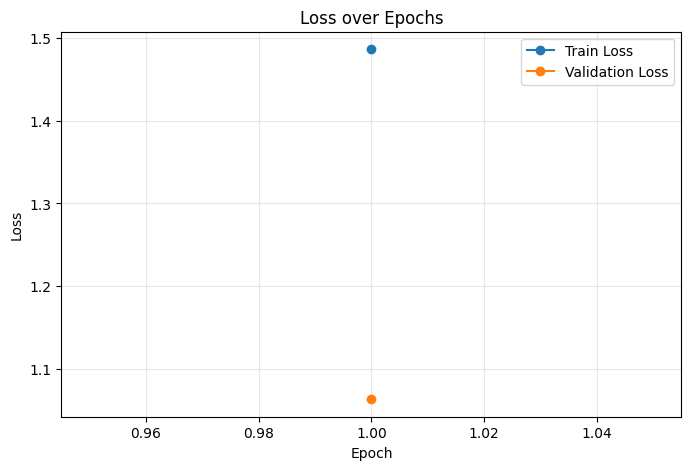

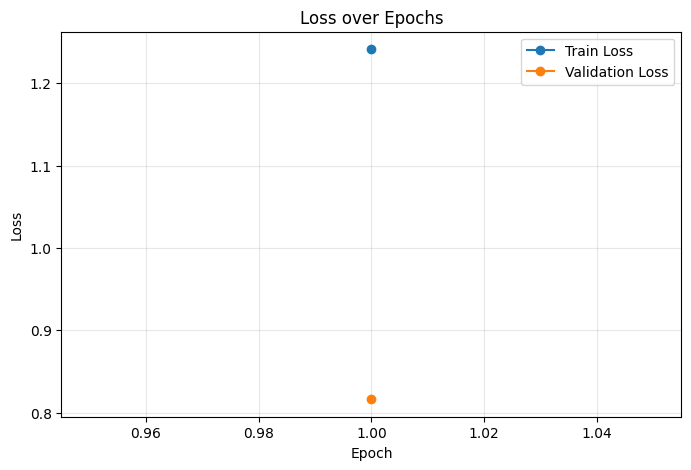

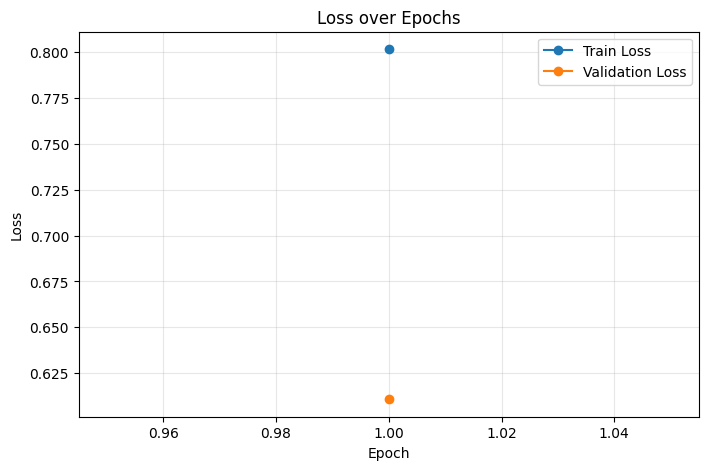

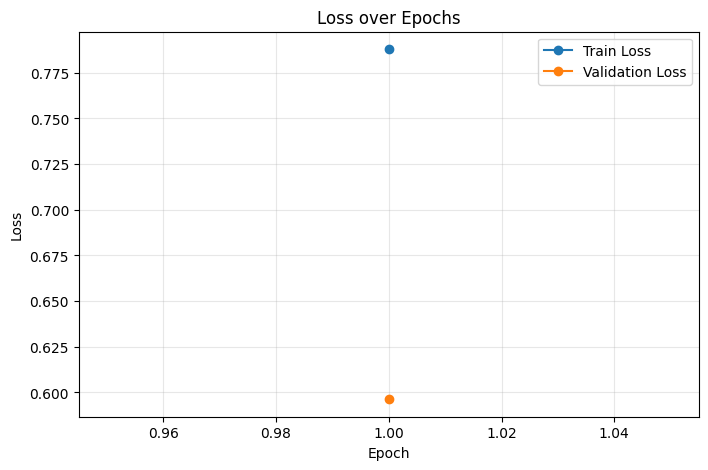

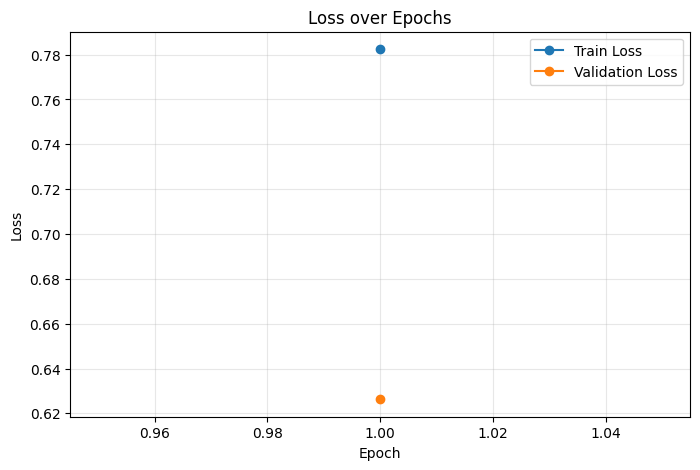

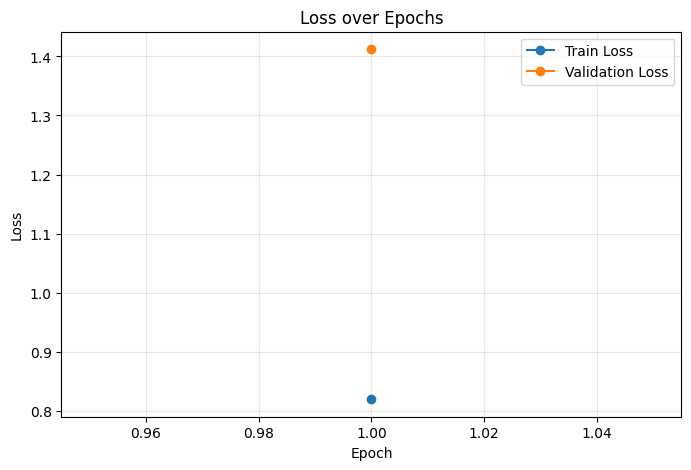

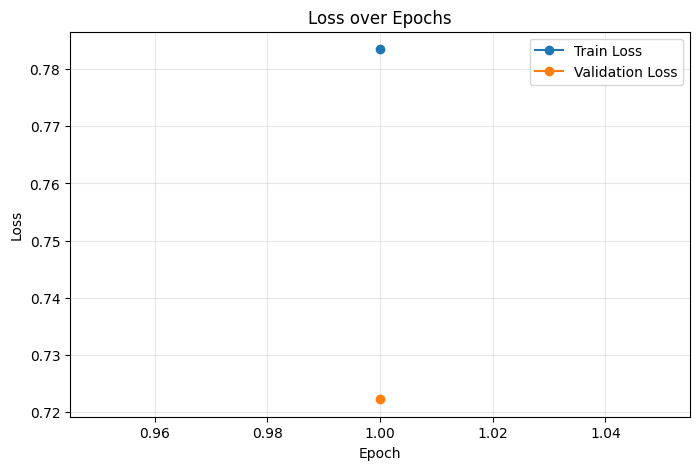

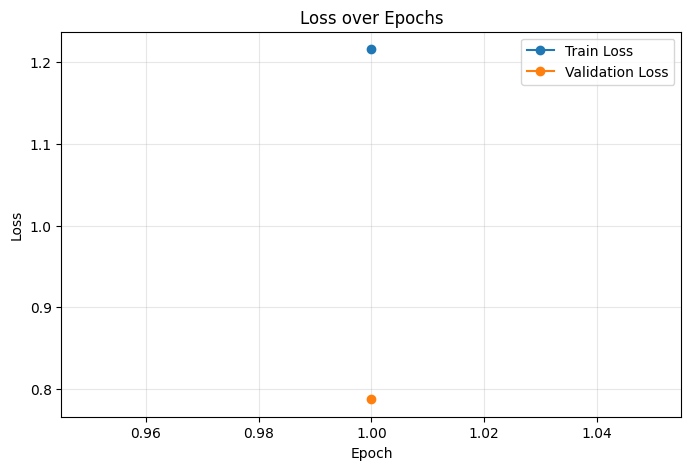

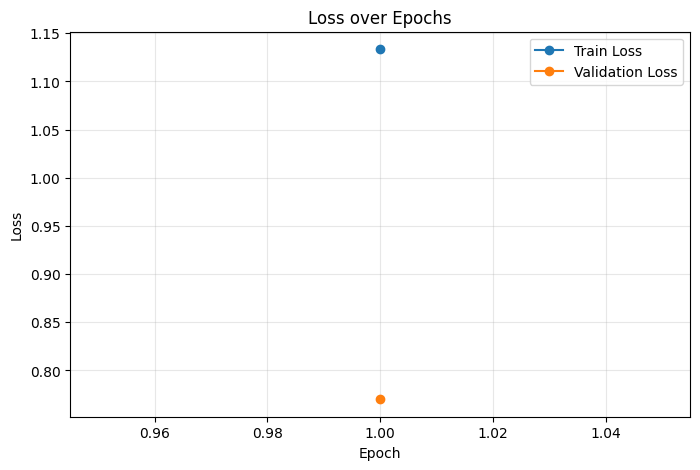

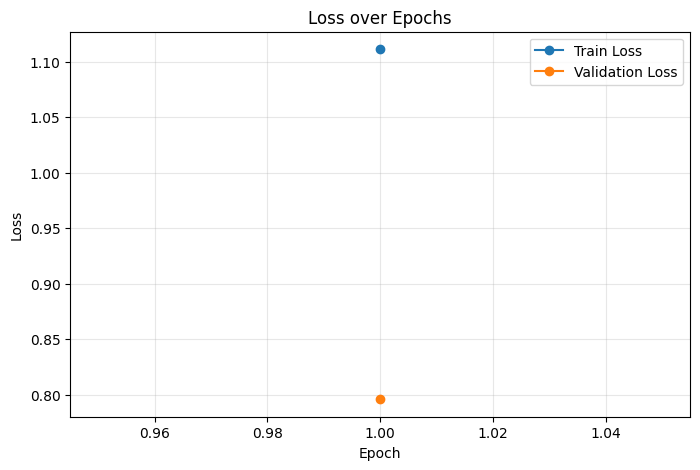

In [12]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")

print("Config:\n", OmegaConf.to_yaml(cfg))

results = []

for seed in cfg.seeds:
    res = run_single_bo_experiment(cfg, seed)
    results.append(res)

# Ergebnisse speichern (Hydra legt automatisch ein Run-Dir an)
import json
out_path = "results/bo_results.json"
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nSaved results to {out_path}")
print("All seeds done.")
